In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pickle
import dicom

In [ ]:
# path_trimmed = '/home/gantos/trimmed/'
# patients = [x[:-4] for x in os.listdir(path_trimmed)]
# print ('Number of patients processed..', len(patients))

In [ ]:
# patients_error = []

# for patient in patients:
#     nparray = np.load(path_trimmed + patient + '.npy')
#     if np.amin(nparray) < -1024:
#         patients_error.append(patient)
# print ('Patients with array values < -1024:\t',len(patients_error))


In [2]:
# patients_ok = list(set(patients)-set(patients_error))

# with open('patients_error.txt', 'wb') as fp:
#     pickle.dump(patients_error, fp)

# with open('patients_ok.txt', 'wb') as fp:
#     pickle.dump(patients_ok, fp)

with open('patients_error.txt', 'rb') as fp:
    patients_error = pickle.load(fp)

with open('patients_ok.txt', 'rb') as fp:
    patients_ok = pickle.load(fp)

In [ ]:
# for patient in patients_error[0:2]+patients_ok[0:2]:
#     nparray = np.load(path_trimmed + patient + '.npy')
#     plt.hist(nparray.flatten(), bins=80, color='c')
#     plt.show()

In [3]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [4]:
path_data = '/home/gantos/data/stage1/'
patientsLOAD = {}
patientsLOAD['error'] = {}
patientsLOAD['ok'] = {}
for patient in patients_error[0:2]:
    patientsLOAD['error'][patient] = load_scan(path_data + patient)
for patient in patients_ok[0:2]:
    patientsLOAD['ok'][patient] = load_scan(path_data + patient)
    

In [5]:
# convert the single scan values into Hounsfield Units (HUs)

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    print ('\tBefore..')
    print ('\t\tIntercept',slices[0].RescaleIntercept)
    print ('\t\tSlope',slices[0].RescaleSlope) 
    plt.hist(image.flatten(), bins=80, color='c')
    plt.show()
    print ('\t\tmin',np.min(image))
    if slices[0].RescaleIntercept == -1024:
        image[image == -2000] = 0
    else:
        image_min = image.min()
        image[image == image_min] = 4000
        image_min = image.min()
        image[image == 4000] = image_min        
#     counter = 0
#     while np.min(image) < 0:
#         print ('\t\tmin',counter,np.min(image))
#         image[image == np.min(image)] = 0
#         counter += 1   
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    # study this range of values - maybe not exactly at -2000
    print ('\tAfter air removal..')
    print ('\t\tIntercept',slices[0].RescaleIntercept)
    print ('\t\tSlope',slices[0].RescaleSlope) 
    plt.hist(image.flatten(), bins=80, color='c')
    plt.show()
    print ('\t\tmin',np.min(image))
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    print ('\tAfter HU..')
    print ('\t\tIntercept',slices[0].RescaleIntercept)
    print ('\t\tSlope',slices[0].RescaleSlope) 
    plt.hist(image.flatten(), bins=80, color='c')
    plt.show()
    print ('\t\tmin',np.min(image))
    return np.array(image, dtype=np.int16)

PATIENT	----- 68a1f729eb1e2a791fe8170ac6631828 ----- error
	Before..
		Intercept 0
		Slope 1


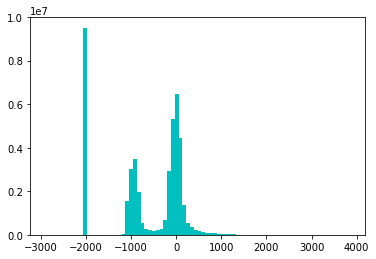

		min -2895
	After air removal..
		Intercept 0
		Slope 1


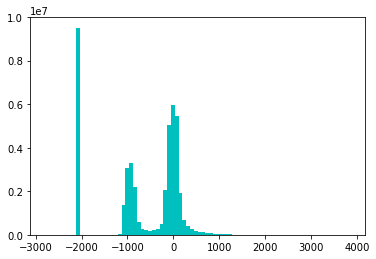

		min -2788
	After HU..
		Intercept 0
		Slope 1


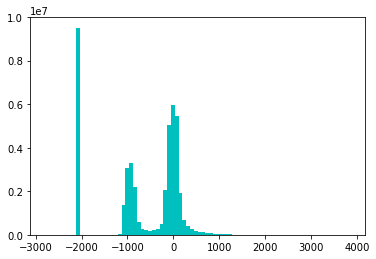

		min -2788
PATIENT	----- 6cf71f5017945c9dd8bc0f5126eeef5b ----- error
	Before..
		Intercept 0
		Slope 1


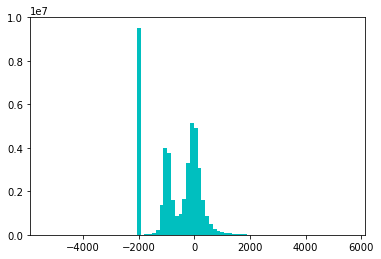

		min -5361
	After air removal..
		Intercept 0
		Slope 1


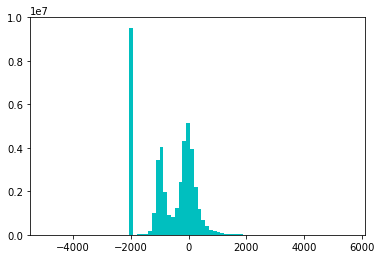

		min -4968
	After HU..
		Intercept 0
		Slope 1


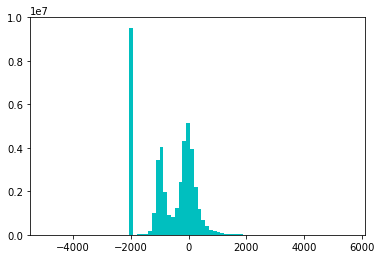

		min -4968
PATIENT	----- d89499632a4c7bde0923003497ffc5ea ----- ok
	Before..
		Intercept -1024
		Slope 1


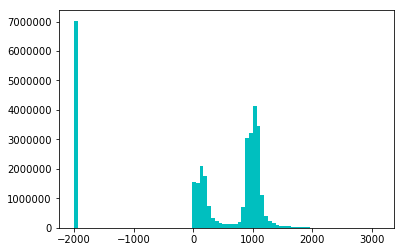

		min -2000
	After air removal..
		Intercept -1024
		Slope 1


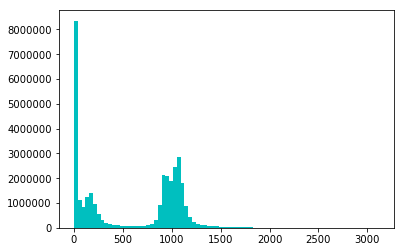

		min 0
	After HU..
		Intercept -1024
		Slope 1


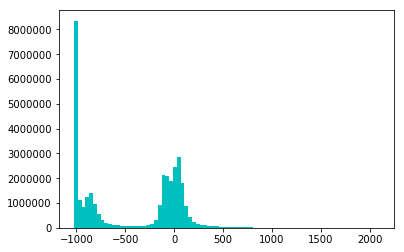

		min -1024
PATIENT	----- 03bd22ed5858039af223c04993e9eb22 ----- ok
	Before..
		Intercept -1024
		Slope 1


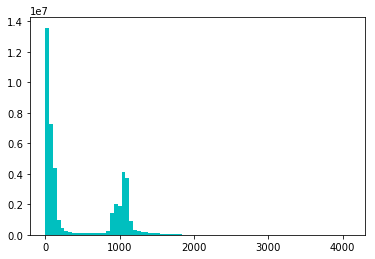

		min 0
	After air removal..
		Intercept -1024
		Slope 1


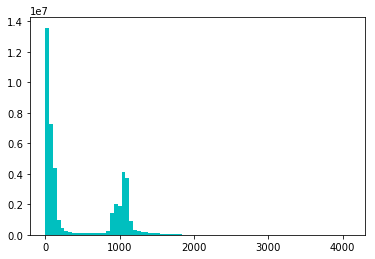

		min 0
	After HU..
		Intercept -1024
		Slope 1


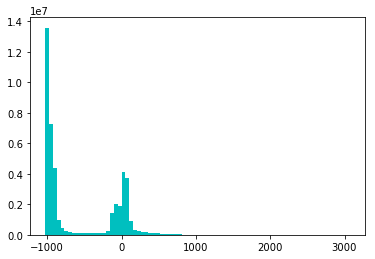

		min -1024


In [6]:
patientsHU = {}
patientsHU['error'] = {}
patientsHU['ok'] = {}
for category in patientsLOAD.keys():
    for patient in patientsLOAD[category].keys():
        print ('PATIENT\t-----',patient,'-----',category)
        patientsHU[category][patient] = get_pixels_hu(patientsLOAD[category][patient])

In [7]:
# 3-D plots a single scan

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

Ok d89499632a4c7bde0923003497ffc5ea


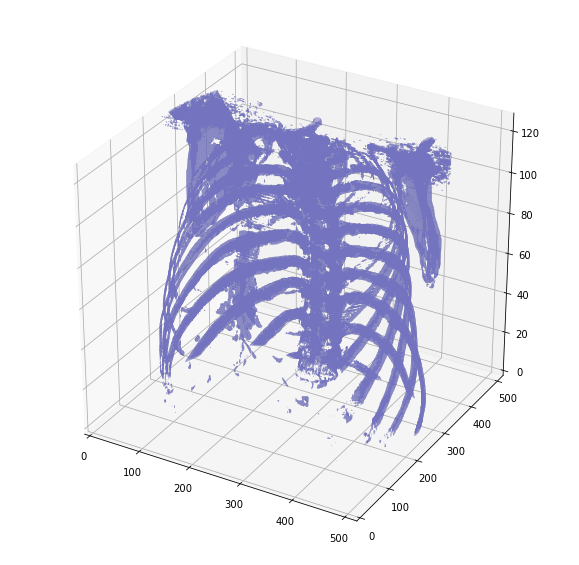

Ok 03bd22ed5858039af223c04993e9eb22


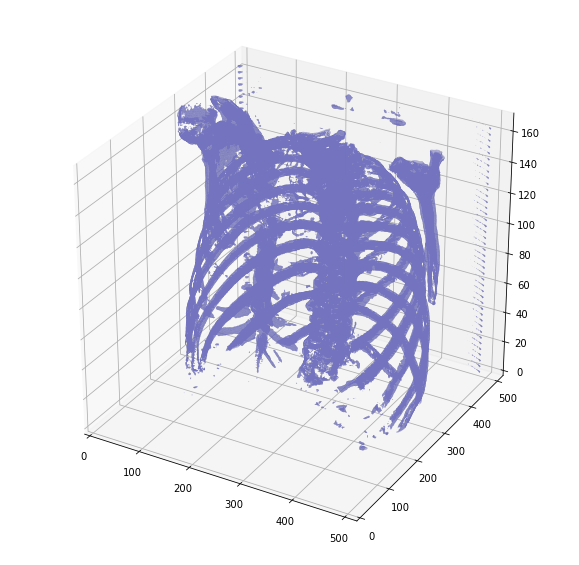

In [ ]:
for patient in patientsHU['ok'].keys():
    print ('Ok',patient)
    plot_3d(patientsHU['ok'][patient], 400)

Error 68a1f729eb1e2a791fe8170ac6631828


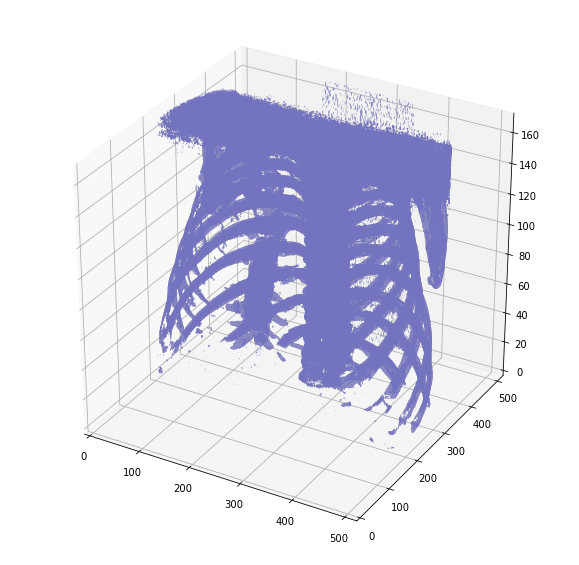

Error 6cf71f5017945c9dd8bc0f5126eeef5b


In [ ]:
for patient in patientsHU['error'].keys():
    print ('Error',patient)
    plot_3d(patientsHU['error'][patient], 400)

In [8]:
# segments a single scan between lung and non-lung

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [9]:
# segment_lung_mask example dictionary

patientsMASK = {}
patientsMASK['error'] = {}
patientsMASK['ok'] = {}
for category in patientsLOAD.keys():
    for patient in patientsLOAD[category].keys():
        print ('PATIENT\t-----',patient,'-----',category)
        patientsMASK[category][patient] = segment_lung_mask(patientsHU[category][patient])


PATIENT	----- 68a1f729eb1e2a791fe8170ac6631828 ----- error
PATIENT	----- 6cf71f5017945c9dd8bc0f5126eeef5b ----- error
PATIENT	----- d89499632a4c7bde0923003497ffc5ea ----- ok
PATIENT	----- 03bd22ed5858039af223c04993e9eb22 ----- ok


Ok d89499632a4c7bde0923003497ffc5ea


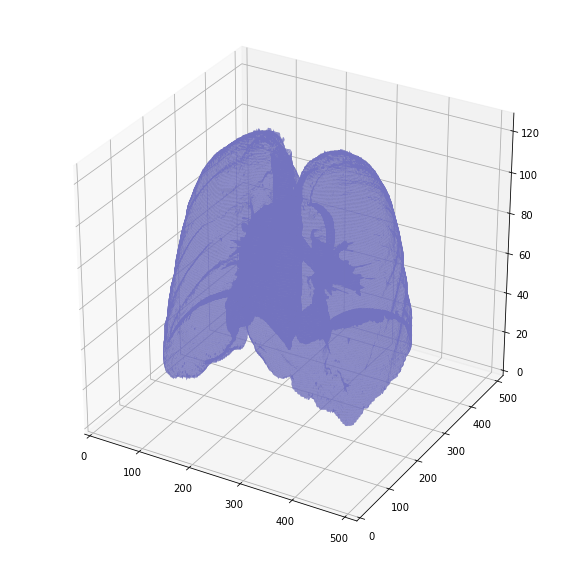

Ok 03bd22ed5858039af223c04993e9eb22


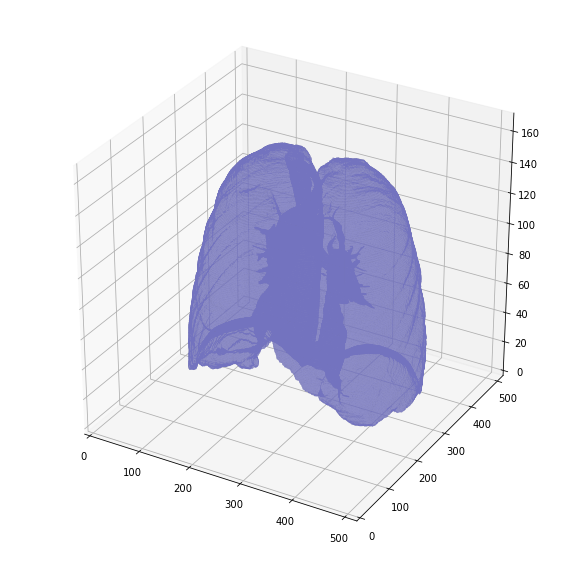

In [11]:
for patient in patientsMASK['ok'].keys():
    print ('Ok',patient)
    plot_3d(patientsMASK['ok'][patient], 0)

Error 68a1f729eb1e2a791fe8170ac6631828


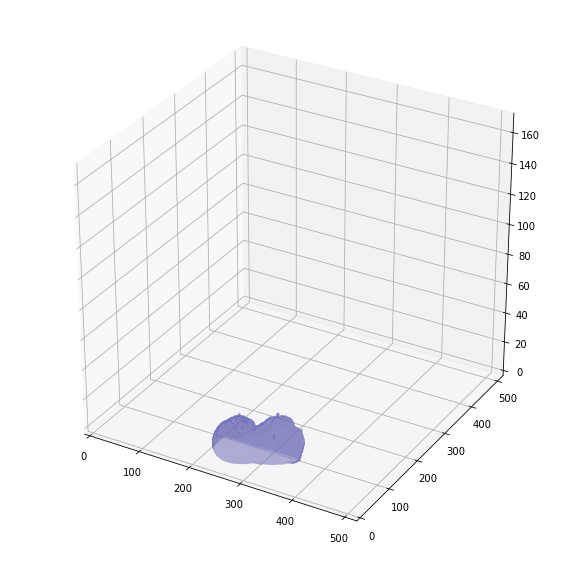

Error 6cf71f5017945c9dd8bc0f5126eeef5b


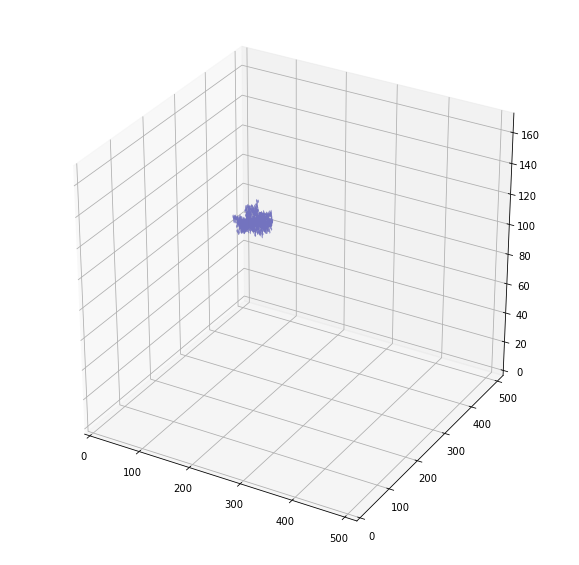

In [12]:
for patient in patientsMASK['error'].keys():
    print ('Error',patient)
    plot_3d(patientsMASK['error'][patient], 0)